### Run in Google Colab

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1rGr4KzvNvvefl4pWQktsNYZPbHW9lLLy#scrollTo=tUnCzswVW7rg)

### Setup your API key

Before you can use the OpenAI API, you must first obtain an API key. If you don't already have one, create a key for OPENAI_API_KEY which is obtained from: https://openai.com/blog/openai-api

In Colab, add the key to the secrets manager under the "🔑" in the left panel. Give it the name `OPENAI_API_KEY`.


### Mount this Colab notebook at Google Drive
To ensure your work is saved and can be accessed later, it's a good practice to mount your Google Drive to this Colab notebook. You can do this by running the following code. This will prompt you to authorize Colab to access your Google Drive account. After authorization, your Google Drive will be mounted, and you can save your files directly to it.

In [ ]:
# Used to securely store your API key
from google.colab import userdata
api_key = userdata.get('OPENAI_API_KEY')

# Mount google drive in the virtual envrionment
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install langgraph==0.2.4
!pip install langchain-community==0.2.12
!pip install langchain-openai==0.1.22
!pip install langchain-experimental==0.0.64

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 584.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.9/393.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.9/148.9 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.8/997.8 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3

In [ ]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI

In [ ]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

class Agent:

    def __init__(self, model, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("unit_conversion", self.call_openai_unit_conversion)
        graph.add_node("object_extraction", self.call_openai_object_extraction)
        graph.add_node("object_creation", self.call_openai_object_creation)
        graph.add_edge("unit_conversion", "object_extraction")
        graph.add_edge("object_extraction", "object_creation")
        graph.set_entry_point("unit_conversion")
        graph.set_finish_point("object_creation")
        self.graph = graph.compile()
        self.model = model

    def call_openai_unit_conversion(self, state: AgentState):
        system_message = """
        This agent node updates the building description to use the correct SI \
        units (International System of Units) while keeping the rest of the \
        description unchanged.
        """
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=system_message)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def call_openai_object_extraction(self, state: AgentState):
        system_message = """
        This agent node processes building description under SI unit to create \
        a object dictionary about 1) material/construction, 2) internal load \
        (people, lights, electric equipment, infiltration), and 3) HVAC \
        system. The dictionary's keys are the EnergyPlus IDF object type and \
        its name to be created in tuple format (object type in str, object \
        name in str, object name cannot be the same as object type), and the \
        values to be detailed description or requirement of the IDF object, in \
        string format.
        """
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=system_message)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def call_openai_object_creation(self, state: AgentState):
        system_message = """
        This agent node generates all text-based idf objects for EnergyPlus \
        simulations from the extracted object dictionary.
        Some general rules when generating the object:
        - Start with filling out default values for all fields.
        - Fill out or replace the value that can be extracted from the object \
        dictionary
        - If the field is not mandatory and is not defined by the specific \
        requirement, leave the value blank in the field.
        - If the field is mandatory but not defined by the specific \
        requirement, set it to "TBD" (to be defined).
        - Even though some fields are optional or not defined by the specific \
        requirement, keep them in the object and do not remove them.
        - In the generated object, comment after "!" for each field about why \
        the value is set or is left blank.
        """
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=system_message)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

In [ ]:
prompt = """
The users need to provide a building description or specification, covering \
various aspects such as construction, internal load, and HVAC systems, along \
with any specific requirements for these elements. The first agent node called \
unit conversion conducts unit conversions to standardize the units across the \
description. The second agent node called object_extraction decides what IDF \
objects to create and extracts unstructured texts about these IDF objects from \
the description. Finally, the third agent node called object_creation \
generates structured text-based IDF objects for each object to be created, \
adhering to the IDF syntax.
"""

model = ChatOpenAI(temperature=0, model="gpt-4o", openai_api_key = api_key)
abot = Agent(model, system=prompt)

In [ ]:
user_input = """
iUnit is a modular apartment located at the campus of National Renewable \
Energy Laboratory (NREL) that can be moved indoor for guarded testing or \
outdoor for environmental testing. NREL is using iUnit to conduct \validation-\
grade energy simulation experiments.

1. Constructions
1.1. Floor
Floor Layer 1 (Outside): Rodent Barrier (HDPE)
Roughness: Smooth; Thickness: 0.05 in; Conductivity: 3.472 Btu·in/hr·ft2·R; \
Density: 59.3 lb/ft3; Specific Heat: 0.4347 Btu/lb·R
Floor Layer 2: Insulated Joist Layer
Roughness: Smooth: Thickness: 14.462 in; Conductivity: 0.3323 Btu·in/hr·ft2·R; \
Density: 6.336 lb/ft3; Specific Heat: 0.2357 Btu/lb·R
Floor Layer 3: OSB
Roughness: Smooth: Thickness: 1.75 in; Conductivity: 0.826 Btu·in/hr·ft2·R; \
Density: 33.96 lb/ft3; Specific Heat: 0.289 Btu/lb·R
Floor Layer 4 (Inside): Plywood
Roughness: Smooth; Thickness: 0.25 in; Conductivity: 0.8 Btu·in/hr·ft2·R; \
Density: 33.96 lb/ft3; Specific Heat: 0.289 Btu/lb·R

2. Internal Loads
2.1. People
Internal load “People” strictly follows the NREL’s business hours, 1) Monday–\
Thursday, 8 a.m.–5 p.m., 2) Friday, 8 a.m.–4 p.m., 3) Closed on Saturday and \
Sunday. There are on average two persons in iUnit during business hours and no \
people in time of the rest.
2.2. Lighting
Assume lighting capacity by yourself since it is not measured. This kind of \
assumption of missing values is very common in EnergyPlus. Refer to ASHRAE \
standard. The lighting on/off schedule is assumed to be the same as the \
business hours.

3 Infiltration
The infiltration will be defined using IDF object \
ZoneInfiltration:DesignFlowRate. In this object, according to the onsite \
measurements, I = 1, Fschedule = always on (1,1,1,1,…), A = 0.03, B = 0.003, \
C = 0, D = 0. Apply the infiltration to all zones.

4. HVAC System
Use HVAC template to design automate HVAC system for iUnit.
- Packaged terminal air conditioner (PTAC) systems with hot water boiler
"""

messages = [HumanMessage(content=user_input)]
result = abot.graph.invoke({"messages": messages})

### Results and Visualization

In [ ]:
for i in range(len(result['messages'])):
  print(result['messages'][i].content)


iUnit is a modular apartment located at the campus of National Renewable Energy Laboratory (NREL) that can be moved indoor for guarded testing or outdoor for environmental testing. NREL is using iUnit to conduct alidation-grade energy simulation experiments.

1. Constructions
1.1. Floor
Floor Layer 1 (Outside): Rodent Barrier (HDPE)
Roughness: Smooth; Thickness: 0.05 in; Conductivity: 3.472 Btu·in/hr·ft2·R; Density: 59.3 lb/ft3; Specific Heat: 0.4347 Btu/lb·R
Floor Layer 2: Insulated Joist Layer
Roughness: Smooth: Thickness: 14.462 in; Conductivity: 0.3323 Btu·in/hr·ft2·R; Density: 6.336 lb/ft3; Specific Heat: 0.2357 Btu/lb·R
Floor Layer 3: OSB
Roughness: Smooth: Thickness: 1.75 in; Conductivity: 0.826 Btu·in/hr·ft2·R; Density: 33.96 lb/ft3; Specific Heat: 0.289 Btu/lb·R
Floor Layer 4 (Inside): Plywood
Roughness: Smooth; Thickness: 0.25 in; Conductivity: 0.8 Btu·in/hr·ft2·R; Density: 33.96 lb/ft3; Specific Heat: 0.289 Btu/lb·R

2. Internal Loads
2.1. People
Internal load “People” str

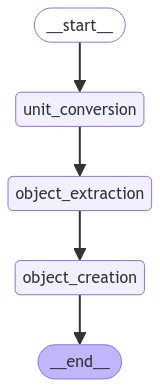

In [ ]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        abot.graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)